In [41]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [42]:
def catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4):
    x1 = 40
    # ncy = 20
    
    Ly = 20
    

    Lx = 100
    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    
    xx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    xx[0:ncx1] = torch.linspace(0,  x1 - x1/ncx1, ncx1, dtype=torch.float)
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + ((x1+x3)/2) * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = (x1+x3)/2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + Lx*xx_ref
    
    yy = torch.zeros(ncx+1, dtype=torch.float).to(device)
    yy[ncx1:ncx1+ncx2] = (xx[ncx1:ncx1+ncx2] - x1)/((x1+x3)/2 - x1)*h
    yy[ncx1+ncx2:ncx1+ncx2+ncx3+1] = (x3 - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1])/(x3 - (x1+x3)/2)*h
    

    dx1 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx2 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx1[0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[0:ncx1+ncx2+1] = x1
    dx1[ncx1+ncx2:] = Lx-(x1+x3)/2
    dx2[ncx1+ncx2:] = Lx-x3

    dx[ncx1+1:ncx1+ncx2] = xx[ncx1+1:ncx1+ncx2]
    dx[ncx1+ncx2:ncx1+ncx2+ncx3+1] = Lx - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1]

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*yy + (h - yy)*dx2) * yy * Delta_x_max
    
    xx = xx + Delta_x
    
    n_periods = 4
    X_Y = torch.zeros((1, n_periods*ncx+1, 2), dtype=torch.float).to(device)
    X_Y[0, -(ncx + 1):, 0], X_Y[0, -(ncx + 1):, 1] = xx, yy
    for i_period in range(1,n_periods):
        X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 0], X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 1] = xx-i_period*100, yy
       
    
    return X_Y, xx, yy


def Theta2Mesh_1d(theta):
    x2, x3, h = theta
    ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
    X_Y, X, Y = catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4)
    return X_Y, X, Y

1d X error =  0.0
1d Y error =  0.0


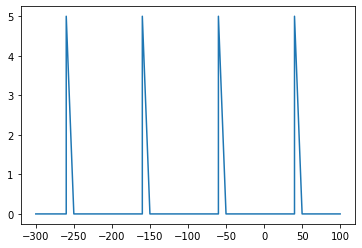

In [43]:
x2, x3, h = 40, 50, 5
ncx1, ncx2, ncx3, ncx4 = 5, 2, 2, 5
X0,Y0 = numpy_catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
X_Y, X, Y = catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))

X_Y = X_Y.cpu().numpy()
plt.plot(X_Y[0, :, 0], X_Y[0, :, 1])

5325953
0 0.01863060798496008 loss =  -193254.0 reg =  0.0
x2, x3, h =  45.00999999999999 49.99000000000001 2.990000000000001


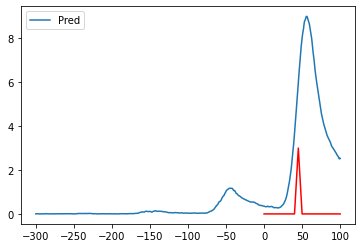

1000 0.012074467726051807 loss =  -303690.15625 reg =  166417.27976366432
x2, x3, h =  58.05369479940822 39.85337730936482 1.0615901769127405


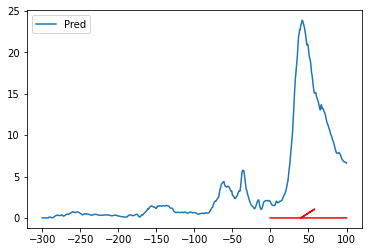

2000 0.012079402804374695 loss =  -463868.875 reg =  193614.14187442226
x2, x3, h =  64.02541204556891 46.756541231692985 1.4283094832565573


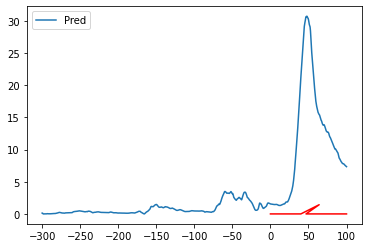

3000 0.012316998094320297 loss =  -434530.1875 reg =  219339.23571498788
x2, x3, h =  66.86789116896726 48.95060376659796 4.3576970492208


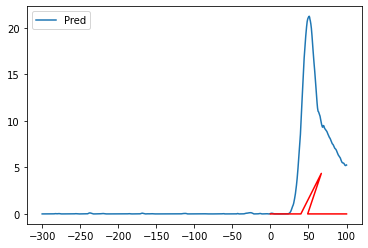

4000 0.012410078197717667 loss =  -456601.6875 reg =  229199.4849125159
x2, x3, h =  67.83901571831106 48.453224580247266 4.152710262713768


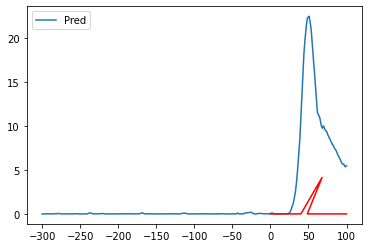

5000 0.011931629851460457 loss =  -493933.4375 reg =  231274.8220979873
x2, x3, h =  67.99164459991623 47.51063558980365 3.257673462055655


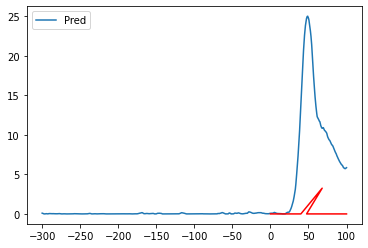

In [45]:
################################################################
# inverse optimization for 1d
################################################################
n_periods = 4

model = torch.load("catheter_plain_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.01
epochs = 5001
step_size = 1000
gamma = 0.5

theta0 = torch.tensor(np.array([45,50,3], dtype=np.float))
theta = torch.tensor(np.array([45,50,3], dtype=np.float), requires_grad=True)
optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
xx_mask = torch.linspace(-100*(n_periods-1), 100, n_periods*1000+1, dtype=torch.float).to(device)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    x, XC, YC = Theta2Mesh_1d(theta)
    
    
    out = torch.clip(model(x).flatten(), min=0.0)
    
    # maximize negative mean
    loss = -torch.dot(out, xx_mask)
    reg = 1e4*torch.norm(theta - theta0)
    loss_sum = loss + reg
    loss_sum.backward()

    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%step_size==0:
        print(ep, t2 - t1,  "loss = ", loss.item(), "reg = ", reg.item())

        theta_np = theta.detach().cpu().numpy()
        
        x2, x3, h = theta_np
        print("x2, x3, h = ", x2, x3, h)
        
        bottom_x, bottom_y = np.array([0, 40.0, x2, x3, 100.0]),  np.array([0.0, 0, h, 0, 0.0])
        
        plt.figure()
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy(), label="Pred")
        plt.plot(bottom_x, bottom_y, color="r")
        plt.legend()
        plt.show()